# X-ray Absorption Spectroscopy Simulation in the Time-Domain 

X-ray absorption spectroscopy (XAS) is an experimental technique where the absorption of X-rays are measured as a function of incident photon energy to determine oxidation states and local atomic structure. It can be used, for example, to help determine charge degradation mechanisms in candidate materials in battery designs. Simulating XAS was identified as a potential application for early fault-tolerant quantum computers [Fomichev:2024]. This demo will show you how to implement an algorithm developed in the paper "Fast simulations of X-ray absorption spectroscopy for battery materials on a quantum computer" [Fomichev:2025] in PennyLane. 

First, we will discuss why simulating X-ray absorption spectroscopy is useful, and why it is a promising application for early quantum computers. Then we will explain the main steps in the simulation algorithm, and how to implement a simplified version in PennyLane.

We will be using concepts that were introduced in other PennyLane demos, such as utilizing pyscf with PennyLane, initial state preparation of molecules, and building compressed double-factorized Hamiltonians. If you haven't checked out those demos yet, it might be best to do so and then come back here.

## Why simulate X-ray absorption spectroscopy?
Lithium-excess materials are transition metal oxides that have been engineered to accomodate extra Lithium atoms in their structural composition, designed as a candidate for use in battery cathodes. However, repeated charge-discharge cycles can alter the structure and reduce performance. One can study these degraded materials using X-ray absorption spectroscopy, which directly probes local structure by exciting tightly bound core electrons. This can be used to identify oxidation states in materials, because different elements and their oxidation states will absorb photons of different energies. However, this requires reference spectra for each expected degredation outcome in order to determine the composition of structures present in the material. We call this "spectral fingerprinting", where the observed spectrum can be matched to combinations of spectra from small clusters. Simulating these spectra is a difficult task for classical computers -- the highly correlated excited states are difficult to compute classically, particularly for transition metals. However, the relatively small set of eletronic orbitals needed to simulate these small clusters make this simulation task well suited for early quantum computers which will be limited in their number of qubits.

![alt text](XAS_notebook/fingerprinting.png)

## Algorithm

### Absorption cross-section

In XAS experiments, the spectrum observed is a measure of the absorption cross section as a function of the frequency of the incident X-rays $\sigma_A(\omega)$. This is related to the rate of absorption of X-ray photons of various energies. For our situation, the electrons in the molecular cluster start in a ground molecular state $|I\rangle$ with energy $E_I$, and will be coupled to an excited state $|F\rangle$ with energy $E_F$ through the action of the dipole operator $\hat m_\rho$, which represents the effect of the radiative field, where $\rho$ is any of the Cartesian directions $\{x,y,z\}$. 

Let's discuss our intuition behind the absorption cross section. We expect absorption at an X-ray frequency $\omega \approx E_F - E_I $ when there is an excited state with energy $E_F$ such that the overlap between $\hat m_\rho |I\rangle$ and $|F\rangle$ is significant. The rate of that absorption, by Fermi's golden rule, is proportional to the matrix element squared (the overlap) and the density of final states. Due to experimental resolution and excited state lifetime, the density of the final states could be approximated as a Lorentzian with width $\eta$. The full absorption spectrum would look like a sum of those Lorentzian features weighted by the overlap of the final states and the dipole operator applied to the initial state.

With the prefactors included, the absorption cross section is given by

$$ \sigma_A(\omega) = \frac{4 \pi}{3 \hbar c} \omega \sum_{F \neq I}\sum_{\rho=x,y,z} \frac{|\langle F|\hat m_\rho|I \rangle|^2 \eta}{((E_F - E_I)-\omega)^2 + \eta^2}\,, $$

where $c$ is the speed of light, $\hbar$ is Plank's constant, and $\eta$ is the line broadening which here is set by the experimental resolution of the spectroscopy, and is typically around $1$ eV. In general, it could also be related to the lifetime of the excited states. The spectrum we hope to simulate will be proportional to this absorption cross section, with peak positions $E_F-E_I$ and absorption intensities $|\langle F|\hat m_\rho|I \rangle|^2$.

**Insert figure with dummy absorption spectrum, annotating the peak height is the overlap, the position is the energy difference, and the widths are $\eta$.**

To estimate $\sigma_A(\omega)$ we just need to determine the overlaps $|\langle F|\hat m_\rho|I \rangle|^2$ and the energy differences $E_F-E_I$. There are known classical and quantum methods (citations?) for determining the ground state of a molecular cluster $|I\rangle$, its corresponding energy $E_I$ and the action of the dipole operator on that state $m_\rho|I\rangle$ (which we will describe in the implementation). So, to determine the peak positions and intensities of the spetrum we only have to find the energies $E_F$ and final states $|F\rangle$. The states of interest for XAS are known as the core-excited states, where there is a hole in a core orbital due to a high energy excitation. These states are very high energy and exhibit large correlations, expecially in systems with transition metals, making them difficult to calculate with state-of-the-art classical methods. This motivates the development of a quantum algorithm to compute the spectrum. 


### Quantum algorithm in the time-domain
Given $\hat m_\rho |I\rangle$, we can use a mathematical trick called a *frequency-domain Green's function* to understand how to determine the absorption cross section. **Insert intuition for using a Green's function**
<!-- A Green's function is an impulse reponse -->

We can write the cross section as the imaginary part of the following Green's function

$$\mathcal{G}_\rho(\omega) = \langle I|\hat m_\rho \frac{1}{\hat H -E_I -\omega +i\eta} \hat m_\rho |I\rangle\,.$$

If we combine the use of

$$ \mathrm{Im}\left(\frac{1}{x + i\eta}\right) = - \frac{\eta}{x^2 + \eta^2}\,, $$

with inserting a resolution of identity of the final states, we can recover the sum over the excited state overlaps

$$ \mathrm{Im}(\mathcal{G_\rho(\omega)}) = \mathrm{Im}\left[\langle I|\hat m_\rho \frac{1}{\hat H -E_I -\omega +i\eta} \left(\sum_F|F\rangle\langle F|\right)\hat m_\rho |I\rangle \right]\,, $$

$$\mathrm{Im}(\mathcal{G_\rho(\omega)}) = \mathrm{Im}\left(\sum_F \frac{|\langle F|\hat m_\rho|I\rangle|^2}{E_F- E_I -\omega +i\eta}\right)$$

$$\mathrm{Im}(\mathcal{G_\rho(\omega)}) = -\sum_{F\neq I} \frac{|\langle F|\hat m_\rho|I\rangle|^2\eta}{(E_F- E_I -\omega)^2 +\eta^2} + \frac{|\langle I|\hat m_\rho|I\rangle|^2}{\omega^2 +\eta^2}\,.$$

We can change the action of the dipole operator to $\hat m_\rho - \langle I| \hat m_\rho | I \rangle$ to remove the second term. However, the second term is also zero if we centre the frame of reference for our molecular orbitals at the nuclear-charge weighted centre for our molecular cluster of choice, which is how we will deal with this in our implementation. 

Note, we will work with the normalized Green's function
$$ G(\omega) = \mathcal{G(\omega)}/||\hat m_\rho\rangle||^2\,. $$

There are methods for determining this frequency-domain Green's function directly [Fomichev:2024], however, our algorithm will instead aim to calculate the discrete-time *time-domain Green's function* (clock emoji x2) $\tilde G(t_j)$ at times $t_j=j\tau$ where $j$ is the index and $\tau$ is the time interval. $G_\rho(\omega)$ can then be calculated classically through the time-dimain Fourier transform

$$ G_\rho(\omega) = \frac{\tau}{2\pi} \sum_{j=-\infty}^\infty e^{-\eta |t_j|} \tilde G(t_j) e^{i\omega t_j}\,, $$

where $\tau \sim \mathcal{O}(||\hat H||^{-1})$ is chosen so that all eigenstates $|F\rangle$ of relevance are rescaled into the range $[-\pi, \pi)$ **explain**.

The time-domain Green's function can be determined using the expectation value of the time evolution operator (normalized)

$$ \tilde G_\rho(t_j) = \frac{\langle I|\hat m _\rho e^{- i\hat H t_j} \hat m_\rho |I\rangle}{|| \hat m_\rho |I\rangle ||^2}\,. $$

**Insert intuition for this**. A Hadamard test circuit on the time evolution unitary can be used to measure the expectation value for each time $t_j$ by repeating a number of times $N$ and taking the mean of the resutls. See the circuit below.

![alt text](_static/demonstration_assets/xas/hadamard_test_circuit_Stepan2024.png)

To implement the time evolution operator of $H$, we will use a trotter-formula of a compressed double-factorized Hamiltonian, which we will explain in more detail later. This factorization will be done classically in PennyLane. 

To summarize, below is a step-by-step to implement the algorithm:
- Determine $\hat m_\rho|I\rangle$ classically.
- Initialize $\hat m_\rho|I\rangle$ in the quantum register, along with an auxillary qubit for the Hadamard test circuit.
- Apply the time evolution unitary to the state, letting it evolve under the electronic Hamiltonian $H$ for a time $t_j$. 
- Measure the expectation value $\langle I|\hat m_\rho e^{-i \hat H t} \hat m_\rho |I\rangle$ of that evolved state.
- Repeat for a number of shots $N$ for each time $t_j$ for $j \in [0, j_\mathrm{max}]$ to obtain the time-domain Green's function $\tilde G(t_j)$.
- Fourier transform $\tilde G(t_j)$ to obtain a the frequency-domain Green's function $G(\omega)$, which is related to the absorption spectrum.

![alt text](XAS_notebook/block_diagram_of_algorithm.png)

## Implementation
Let's look at how to implement these steps in PennyLane. We will make extensive use of the `qml.qchem` module, as well as modules from `pyscf`. 

For this demo, we are going to use the very simple $H_2$ molecule. **Mention lack of optimizations and assumption that you might have to imploy for more complicated materials.**

### Initial state preparation
If you haven't, check out the demo "Initial state preparation for quantum chemistry". 

We start by creating our molecule object using the Gaussian type orbitals module (`pyscf.gto`), and obtaining the reduced Hartree-Fock molecular orbitals with the self-consistent field methods (`pyscf.scf`).

In [26]:
from pyscf import gto, scf
import numpy as np

# Create a Mole object
r = 0.71  # Bond length in Angstrom
symbols  = ['H', 'H']
geometry = np.array([[0.0, 0.0, -r/2],
                     [0.0, 0.0, r/2]])
basis = '631g'
mol = gto.Mole(atom=zip(symbols, geometry), basis=basis, symmetry=None)
mol.build(verbose=0)

# Get molecular orbitals
hf = scf.RHF(mol)
hf.run(verbose=0)
n_orb = hf.mol.nao  # number of atomic orbitals

# Guarantee nuclear charge centre is at the origin
charges, coords = (hf.mol.atom_charges(), hf.mol.atom_coords())
nuc_charge_center = np.einsum('z,zx->x', charges, coords) / charges.sum()
print("nuc charge centre", nuc_charge_center)
hf.mol.set_common_orig_(nuc_charge_center)

nuc charge centre [0. 0. 0.]


Next we will use the configuration interaction singles and doubles methods (`pyscf.ci`) to solve for the ground state of the molecule. We will then import the state into PennyLane using `qml.qchem.import_state`.

In [2]:
from pyscf import ci
import pennylane as qml

myci = ci.CISD(hf).run(verbose=0)

# Ground state wavefunction.
wf_ci = qml.qchem.import_state(myci, tol=1e-5)

# Ground state energy.
E_i = myci.e_tot
print("E_i: ", np.round(E_i, 4), 'Ha')

E_i:  -1.1508 Ha


### Dipole operator action

Let's discuss how the dipole operator acts on the initial state. The dipole operator $\hat m = -q \cdot \hat r$ will only affect the spatial component of the wavefunction -- it does not care about spin. To determine the action of the dipole operator in the molecular orbital basis, we use two resolutions of identity to introduce the molecular orbital wavefunctions $|k\rangle$

$$ \hat m_\rho = -q \cdot \hat r= -q \sum_{ij} |i\rangle \langle i| \hat r |j\rangle \langle j|\,. $$

Then, we simplify by noticing that $|i\rangle \langle j| = c_i^\dagger c_j$ where $c_k^{(\dagger)}$ is the annihilation (creation) operator for orbital $k$. That gives us

$$ \hat m = -q \sum_{ij} \langle i|\hat r |j\rangle c_i^\dagger c_j\,. $$

To calculate the matrix elements $\langle i|\hat r |j\rangle$, we again insert sums over basis states, this time in the position basis. The matrix elements are then integrals of orbitals 

$$ \langle i|\hat r |j\rangle = \int d^3r' d^3r'' \langle i|r'\rangle \langle r' |\hat r | r'' \rangle \langle r'' | j \rangle = \int d^3r' d^3r'' \phi_i(r') r \phi_j^*(r'') \,, $$

where $\phi_k(r)$ are the orbital spatial wavefunctions. 

<!-- These matrix elements can be computed in `pyscf` using the the `intor` method of the `mol` object with argument `'int1e_r_cart'` to specify a one-electron integral with a position $r$ factor. Keyword argument `comp=3` will give us all three components. -->

**Will likely replace the following with a PennyLane `dipole_moment` implementation.**

In [3]:
dip_ints = hf.mol.intor('int1e_r_cart', comp=3)

We can then transform to the molecular orbital space using `np.einsum` and the `mo_coeff` method of `hf`. 

In [4]:
orbcas = hf.mo_coeff
dip_ints = np.einsum('ik,xkl,lj->xij', orbcas.T, dip_ints, orbcas)

What's left is to code the action of the ladder operators $c_i^\dagger c_j$.

**Explain ladder operator implementation, and insert code below to actually compute `dipole_rho`. Right now I'm just inputting the result.**

In [5]:
## INSERT CODE ##
dipole_rho = {(2, 1): -0.6902564137617815, (1, 2): -0.6902564137617815,
                (8, 1): -0.1327113674508237, (1, 8): -0.1327113674508237,
                (2, 4): -0.07024799874988287, (8, 4): 0.031606880290424764,
                (4, 2): -0.07024799874988287, (4, 8): 0.03160688029042472}

dipole_norm = 1.3058

Finally, we can convert our vector into a PennyLane state vector using `qchem.convert._wfdict_to_statevector`, so that it is ready to be initialized in a circuit. 

In [6]:
from pennylane.qchem.convert import _wfdict_to_statevector

wf_dip = _wfdict_to_statevector(dipole_rho, n_orb)

Let's prepare the circuit that will initialize our qubit register with this state. We will need $n_\mathrm{orb}$ wires to load the full state, and we'll need one auxiliary qubit, which we will prepare as the 0 wire with a Hadamard gate.

In [7]:
import pennylane as qml

# initialization circuit for m_rho|I>
device_type = "lightning.qubit"

dev_prop = qml.device(device_type, wires=int(2*n_orb) + 1, shots=None)
@qml.qnode(dev_prop)
def initial_circuit(wf):
    # dipole wavefunction preparation
    qml.StatePrep(wf, wires=dev_prop.wires.tolist()[1:])
    qml.Hadamard(wires=0)
    return qml.state()

### Molecular Hamiltonian

Our electronic Hamiltonian is

$$ H = E + \sum_{p,q=1}^N \sum_{\gamma\in\{\uparrow,\downarrow\}} (p|\kappa|q) a^\dagger_{p\gamma}a_{q\gamma} + \frac12 \sum_{p,q,r,s=1}^N\sum_{\gamma,\beta\in\{\uparrow,\downarrow\}} (pq|rs) a^\dagger_{p\gamma}a_{q\gamma} a^\dagger_{r\beta}a_{s\beta} \,, $$

where $a^{(\dagger)}_{p\gamma}$ is the annihilation (creation) operator for a molecular orbital $p$ and spin $\gamma$, $E$ is the core constant, $N$ is the number of spatial orbitals, and $(p|\kappa|q)$ and $(pq|rs)$ are the one- and two-electron integrals, respectively. 

Luckily, the core constant and the one- and two-electron integrals can be computed using in PennyLane using `qml.qchem.integrals`.

In [ ]:
# Create qml Molecule object.
mole = qml.qchem.Molecule(symbols, geometry, basis_name='6-31g', unit='angstrom')

# Compute core constant and one- and two-electron integrals.
core_const, one, two = qml.qchem.electron_integrals(mole)()

# Re-write in Chemist's notation.
two_chemist = np.einsum('prsq->pqrs', two)
one_chemist = one - np.einsum('pqrr->pq', two)/2.
core_const = core_const[0]

Go read the demo "How to build compressed double-factorized Hamiltonians" if you haven't, because that is exactly what we are going to do!

Compressed double-factorizeding (CDF) our molecular Hamiltonian will be perfect for our application -- it will be much easier to time propagate. We will approximate the evolution operator $e^{-iHt}$ with a Trotter product formula, where the factorized Hamiltonian will allow much faster simulation.

**I think I need to explain the Jordan-Wigner mapping here explicitly, showing the one-body extra, and the new rotation matrices and how they can be implemented with Thouless' theorem. Specifically how to go from what looks like two U rotations to just one when using the `qml.BasisRotation`, and explain one-body extra term as the one-qubit Pauli-Z terms. Or maybe I can just refer to the other demo.**

We can apply CDF to the two-electron integrals using `qml`'s `qchem.factorize` function, with `compressed=True`. 

In [27]:
# Factorize hamiltonian, producing matrices.
_, Z, U = qml.qchem.factorize(two_chemist, compressed=True)

print("Shape of the factors: ")
print("two_chemist", two_chemist.shape)
print("U", U.shape)
print("Z", Z.shape)

# Compare factorized two-electron term to original
approx_two_chemist = qml.math.einsum("tpk,tqk,tkl,trl,tsl->pqrs", U, U, Z, U, U)
assert qml.math.allclose(two_chemist, approx_two_chemist, atol=1.5e-3)

Shape of the factors: 
two_chemist (4, 4, 4, 4)
U (8, 4, 4)
Z (8, 4, 4)


Finally, we add the one-body correction to the one-electron integrals, and use `np.linalg.eigh` to diagonalize them into the matrix $Z^{(0)}$ and obtain the rotation matrices $U^{(0)}$.

In [10]:
# calculate the one-body correction
Z_prime = np.stack([np.diag(np.sum(Z[i], axis = -1)) for i in range(Z.shape[0])], axis = 0)
one_body_correction = np.einsum('tpk,tkk,tqk->pq', U, Z_prime, U)

# Diagonalize the one-electron integral matrix while adding the one-body correction
eigenvals, U0 = np.linalg.eigh(one_chemist + one_body_correction)
Z0 = np.diag(eigenvals)


### Time-propagation circuit

The main work of our algorithm will be to apply our Hamiltonian terms as a trotter product, and measure the expectation value of that time evolution for various times. Let's start by writing functions that implement the time evolution for each Hamiltonian term, which will be called by our trotter circuit. One thing to track throughout this implementation is the global phase accrued throughout the time evolution. Starting with the $U$ operator rotations, we can write a function that uses `qml.BasisRotation` to apply the unitary transform we want. We apply this to both spin sections of the register.

In [11]:
def U_rotations(U, control_wires):
    """Circuit implementing the basis rotations of the CDF decomposition."""
    norb = U.shape[-1]
    qml.BasisRotation(unitary_matrix=U, wires = [int(2*i+control_wires) for i in range(norb)])
    qml.BasisRotation(unitary_matrix=U, wires = [int(2*i+1+control_wires) for i in range(norb)])

Next we write a function to perform the $Z$ rotations. To simplify the Trotter function we will write next, we can condition the action in this function on whether it's acting for a one-body or a two-body term.

In [ ]:
from itertools import product

def Z_rotations(Z, step, is_one_body_term, control_wires):
    """Circuit implementing the Z rotations of the CDF decomposition."""
    norb = Z.shape[-1]

    if is_one_body_term:
        for sigma in range(2):
            for i in range(norb):
                if abs(Z[i, i]) > 1e-15:
                    qml.ctrl(qml.X(wires=int(2*i+sigma+control_wires)),
                                        control = range(control_wires), control_values=0)
                    qml.RZ(-Z[i, i]*step/2, wires=int(2*i+sigma+control_wires))
                    qml.ctrl(qml.X(wires=int(2*i+sigma+control_wires)),
                                        control = range(control_wires), control_values=0)
        globalphase = np.sum(Z)*step

    else:  # a two body term
        for sigma, tau in product(range(2), repeat=2):
            for i, k in product(range(norb), repeat=2):
                if (i != k or sigma != tau) and abs(Z[i, k]) > 1e-15:  # Two body term
                    qml.ctrl(qml.X(wires=int(2*i+sigma+control_wires)), 
                            control = range(control_wires), control_values=0)
                    qml.MultiRZ(Z[i, k]/8.*step,
                            wires=[int(2*i+sigma+control_wires), int(2*k+tau+control_wires)])
                    qml.ctrl(qml.X(wires=int(2*i+sigma+control_wires)),
                            control = range(control_wires), control_values=0)
        globalphase = np.trace(Z)/4.*step - np.sum(Z)*step + np.sum(Z)*step/2.

    qml.PhaseShift(-globalphase, wires = 0)

Let's define our Trotter step. The function will implement $U$ rotations and $Z$ rotations. By tracking the last $U$ rotation used, we can implement two consequtive rotations at once as $V^{(\ell)} = U^{(\ell-1)}(U^{(\ell)})^T$, halving the number of rotations required per Trotter step. 

Below, we define a function `LieTrotter` which applies the rotations for the one- and two- body terms in one order, but can also reverse the order. This can save another rotation step when we implement two consecutive Trotter steps in the second-order Trotter scheme.

In [ ]:
def LieTrotter(step, prior_U, final_rotation, reverse=False):
    """Implements a first-order Trotterized circuit for the CDF."""
    _U0 = np.expand_dims(U0, axis = 0)
    _Z0 = np.expand_dims(Z0, axis = 0)
    _U = np.concatenate((_U0, U), axis = 0)
    _Z = np.concatenate((_Z0, Z), axis = 0)

    num_two_electron_terms = U.shape[0]
    is_one_body = np.array([True] + [False]*num_two_electron_terms)
    order = list(range(len(_Z)))

    if reverse: order = order[::-1]

    for term in order:
        U_rotations(prior_U @ _U[term], 1)
        Z_rotations(_Z[term], step, is_one_body[term], 1)
        prior_U = _U[term].T

    if final_rotation: U_rotations(prior_U, 1)

    qml.PhaseShift(-core_const*step, wires=0)

    return prior_U

Our function `trotter_circuit` implements a second-order Trotter step, returning the Trotter step `circuit` which applies `StatePrep` to prepare the register in the previous quantum state, and two `LieTrotter` calls.

In [ ]:
def trotter_circuit(dev, state, step):
    """Implements a second-order Trotterized circuit for the CDF."""
    qubits = dev.wires.tolist()

    def circuit():
        # State preparation -- set as previous iteration final state.
        qml.StatePrep(state, wires=qubits)

        # Main body of the circuit.
        prior_U = np.eye(n_orb)  # No inital prior U, so set as identity matrix.
        prior_U = LieTrotter(step/2., prior_U=prior_U, 
                        final_rotation=False, reverse=False)
        prior_U = LieTrotter(step/2., prior_U=prior_U, 
                    final_rotation=True, reverse=True)

        return qml.state()

    return qml.QNode(circuit, dev)

### Simulation parameters

Let's discuss our choice of parameters when running this simulation.
**Discuss $\eta$, $j_\mathrm{max}$, the total number of shots $S$, the Hamiltonian norm $||H||$, the grid of frequencies and the time step $\tau$**.

In [ ]:
eta = 0.05  # Ha
jmax = 40
shots = 1000
H_norm = 1.5
wgrid = np.linspace(-2, +5, 10000)
w_min, w_step = wgrid[0], wgrid[1] - wgrid[0]

tau = np.pi / (2 * H_norm)  # time step
jrange = np.arange(1, 2*int(jmax)+1, 1)
time_interval = tau * jrange

print(f"time step, tau: {tau:.4}")
print(f"time interval: {len(time_interval)}")
print(f"frequency step, w_step: {w_step:.2} Ha")

tau: 1.047
time int: 80
w_step: 0.0007 Ha


### Measurement

To measure the expectation value of the time-propagated state, we use a Hadamard test circuit. **Describe briefly. Also describe double measurement scheme to obtain real and imaginary components in an actual physical implementation. Perhaps also include the circuit diagram for that implementation.**

In [16]:
# measurement circuit
dev_est = qml.device(device_type, wires=int(2*n_orb) + 1, shots=shots)

@qml.qnode(dev_est)
def meas_circuit(state):
    qml.StatePrep(state, wires=dev_est.wires.tolist())
    # measure in PauliX or PauliY to get the real/imag parts
    return [qml.expval(op) for op in \
            [qml.PauliX(wires=0), qml.PauliY(wires=0)]]

## Run Simulation
Finally, we can run the simulation, and calculate the spectrum from the measurement results.

In [ ]:
# Initialize state m_rho|I> (including the auxiliary qubit).
state = initial_circuit(wf_dip)

expvals = np.zeros((2, len(time_interval)))  # Results list initialization.

# Perform time steps.
for i in range(0, len(time_interval)):

    circuit = trotter_circuit(dev=dev_prop, state=state, step=tau)

    # Update state and then measure expectation values.
    state = circuit()
    measurement = meas_circuit(state=state)
    
    expvals[:, i] += np.array(measurement).real

Plotting the time-domain output we obtain the following plot.

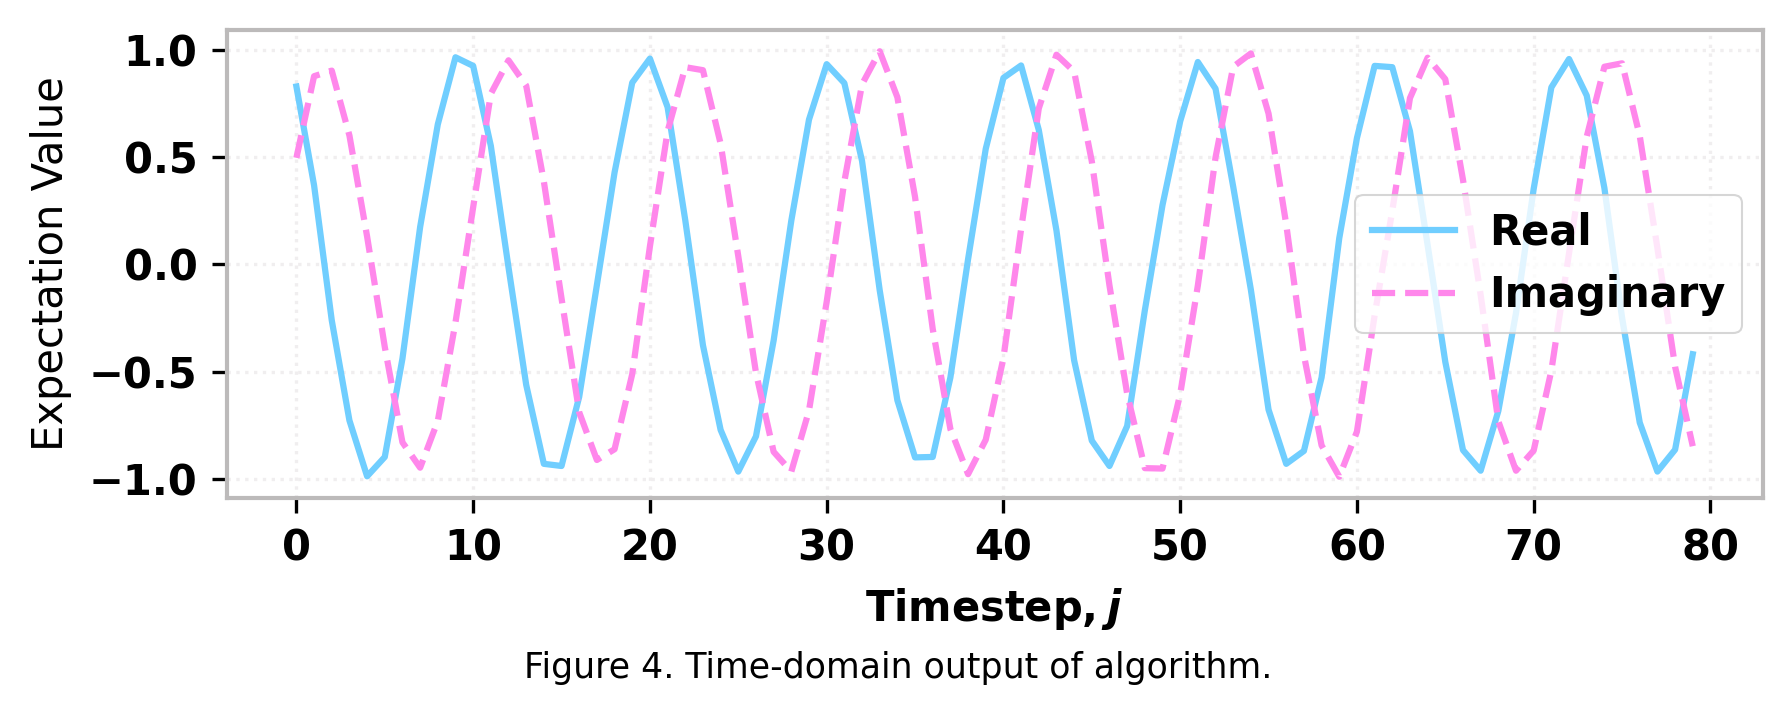

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("pennylane.drawer.plot")

fig = plt.figure(figsize=(6.4, 2.4))
ax = fig.add_axes((0.15, 0.3, 0.8, 0.65))  # Leave space for caption.
ax.plot(range(len(expvals[0, :])), expvals[0, :], label="Real")
ax.plot(range(len(expvals[1, :])), expvals[1, :], label="Imaginary", linestyle="--")
ax.set(xlabel=r"$\mathrm{Time step}, j$", ylabel=r"Expectation Value")
fig.text(0.5, 0.05, "Figure 4. Time-domain output of algorithm.",
    horizontalalignment="center", size="small", weight="normal")
ax.legend()
plt.show()

We can now Fourier transform the output to determine the spectrum.

In [ ]:
L_j = np.exp(-eta * time_interval)
normalized_f_domain_Greens_func = lambda w: tau/(2.*np.pi) * (1 + 2*np.sum(L_j * \
                (expvals[0,:] * np.cos(time_interval*w) \  
                - expvals[1,:] * np.sin(time_interval*w))))

normalized_f_domain_Greens_array = np.array([normalized_f_domain_Greens_func(w) for w in wgrid])
normalized_f_domain_Greens = lambda w: normalized_f_domain_Greens_array[int((w-w_min)//w_step)]

f_domain_Greens = lambda w: dipole_norm**2 * normalized_f_domain_Greens(w)
spectrum = np.array([f_domain_Greens(w) for w in wgrid]).real 

Since $H_2$ is a simple system and our number of orbitals are small, we can easily calculate a classical spectrum for comparison. We do this using the CISD module that we used to determine the ground state, but instead solve for more states. To do this, we will reuse the `myci` instance we created earlier. We then also for the transition density matrix in the molecular orbital basis, $\langle F| \hat m_\rho |I \rangle$. **Explain more what this calculation is.** **Maybe I can just reuse the ao to mo coeff from qml.**

In [ ]:
# Use CISD to solve for excited states.
myci.nroots = 10  # Compute the first 10 states.
myci.run(verbose=0)

# Determine the dipole integrals using pyscf.
dip_ints = hf.mol.intor('int1e_r_cart', comp=3) # In atomic orbital basis.
orbcas = hf.mo_coeff

# Convert to molecular orbital basis.
dip_ints = np.einsum('ik,xkl,lj->xij', orbcas.T, dip_ints, orbcas)

def makedip(ci_id):
    # Transition density matrix in molecular orbital basis.
    t_dm1 = myci.trans_rdm1(myci.ci[0], myci.ci[ci_id])
    # Transition dipole moments.
    return np.einsum('xij,ji->x', dip_ints, t_dm1)

F_m_Is = np.array([makedip(i) for i in range(len(myci.e_tot))])

spectrum_classical_func = lambda E: (1./np.pi) * np.sum( \
        [ np.sum(np.abs(F_m_I)**2) * eta / ( (E-e)**2 + eta**2) \
                        for (F_m_I, e) in zip(F_m_Is, myci.e_tot) ] )

spectrum_classical = np.array([spectrum_classical_func(w) for w in wgrid])

Let's plot and compare the classical and quantum spectra.

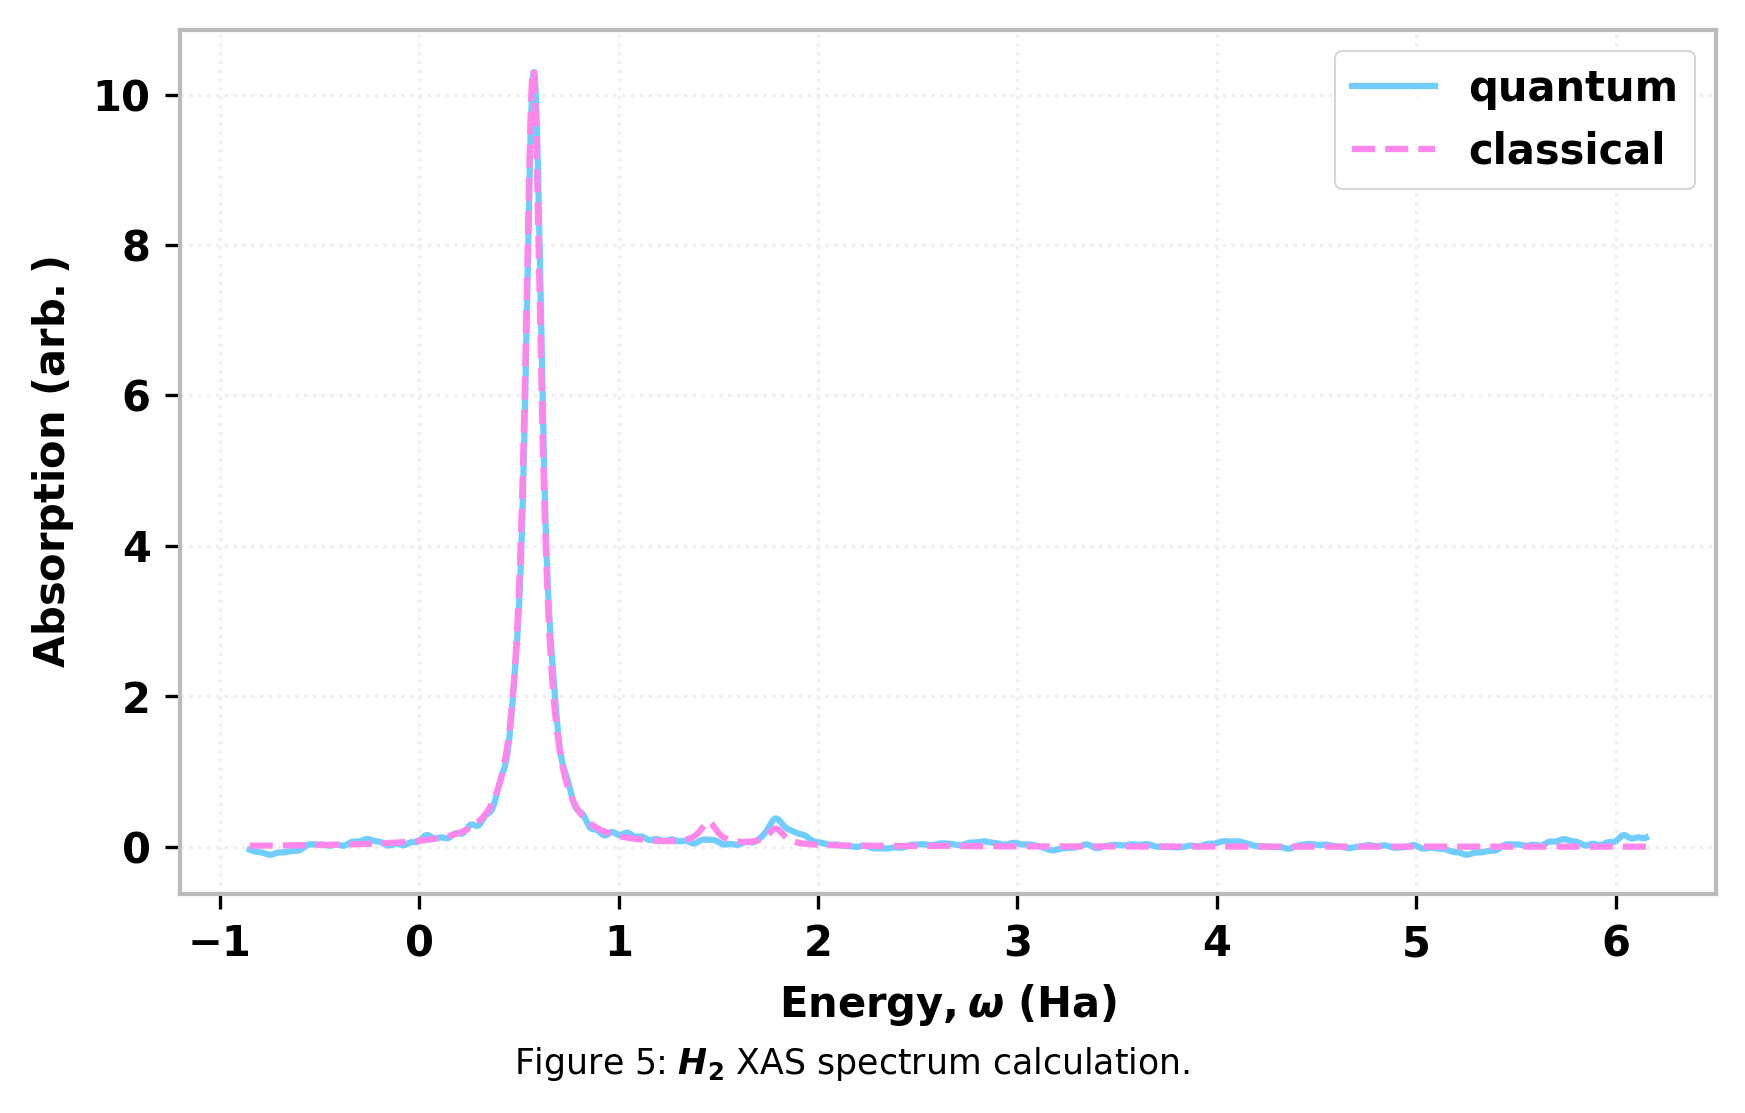

In [ ]:
fig = plt.figure(figsize=(6.4, 4))
ax = fig.add_axes((0.15, 0.20, 0.80, 0.72))  # Make room for caption.

ax.plot(wgrid - E_i, spectrum, label='quantum')
ax.plot(wgrid - E_i, spectrum_classical, '--', label='classical')
ax.set_xlabel(r"$\mathrm{Energy}, \omega\ (\mathrm{Ha})$")
ax.set_ylabel(r"$\mathrm{Absorption\ (arb.)}$")
ax.legend()
fig.text(0.5, 0.05, r"Figure 5: $H_2$ XAS spectrum calculation.",
        horizontalalignment="center", size="small", weight="normal")

plt.show()

**Describe AO and MO character of the states associated with these absorption peaks (maybe?). They should be the |0> to |2>, |7> and |9> transitions. Is there any physical intuition we can give here?**

### Further Optimizations

There are more optimizations mentioned in the paper that were not implemented here. Below is a list of further optimizations:
- Randomized Trotter steps
- BLISS
- Distribution sampling
- Core-valence separation approximation

Could implement some of these, show how they could be implemented, or just describe them. 

### Core-valence separation approximation

We can restrict the range of frequencies, and consequently the range of final states in our calculation, by only considering final states for which *core* electrons are excited, i.e. there exists a hole in the core orbitals. These are known as core-excited states, and lie significally above the valance-excited states in energy. Typically the frequency range is focused on a target atom in a molecular cluster, and also near a transition energy, such as targetting core $1s$ electrons. We will also neglect relativistic corrections, and focus on frequencies for which the dipole approximation is valid, which is the assumption that the wavelength of the radiation is large compared to the extent of the electronic wavefunction.

Atomic species and oxidations states will determine the energy difference between states with different principle quantum numbers, and this difference will show as a peak in spectroscopy, known as the *absorption edge*. Focusing spctroscopy near this edge for $1s$ to $2p$ is called the $K$-edge, and in general X-ray absorption near-edge spectroscopy is known as XANES. We will focus on simulating spectroscopy in this XANES regime.

![alt text](XAS_notebook/core-valence.png)

## Conclusion
In this tutorial, we have implemented a simplified version of the algorithm as presented in [Fomichev:2025]. The algorithm represents a culmination of many optimizations for time-evolving an electronic Hamiltonian. We've also discussed how XAS is a promising candidate for early fault-tolerant quantum computers due to its low qubit overhead but high amount of correlations in the state space. 